### Import Data and Packages

In [1]:
import pandas as pd

aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from sklearn.grid_search import GridSearchCV

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Data Info

In [3]:
print(aisles.info())
aisles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
print(departments.info())
departments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes
None


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
print(order_products__prior.info())
order_products__prior.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB
None


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
print(order_products__train.info())
order_products__train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int64
product_id           1384617 non-null int64
add_to_cart_order    1384617 non-null int64
reordered            1384617 non-null int64
dtypes: int64(4)
memory usage: 42.3 MB
None


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
None


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
print(products.info())
products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Analysis of Orders Data

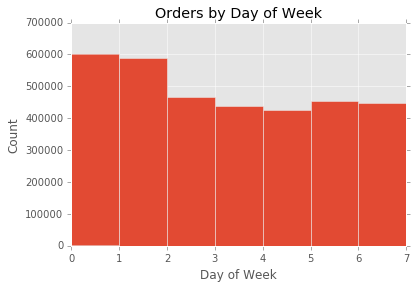

In [9]:
plt.hist('order_dow',data=orders, bins=[0,1,2,3,4,5,6,7])
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Orders by Day of Week')

Day 0 and Day 1 have the most number of orders. It is likely that Day 0 and Day 1 are Saturday and Sunday.

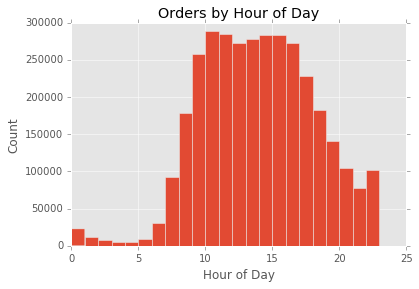

In [10]:
plt.hist('order_hour_of_day',data=orders, bins=np.arange(0,24))
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Orders by Hour of Day')

The peak hours are between 9AM and 5PM but from this plot we cannot really see clearly the corresponding day and time combination. Use heatmap (below) instead.

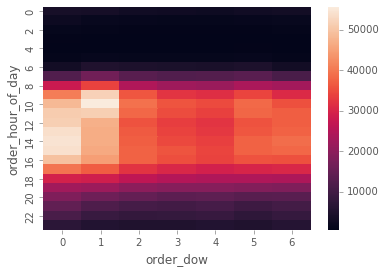

In [11]:
grouped = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].count().reset_index()
grouped = grouped.pivot('order_hour_of_day', 'order_dow', 'order_number')
sns.heatmap(grouped)

From the heatmap, the peak day and hours combination occurs on day 0 and day 1 between 9AM and 5PM.

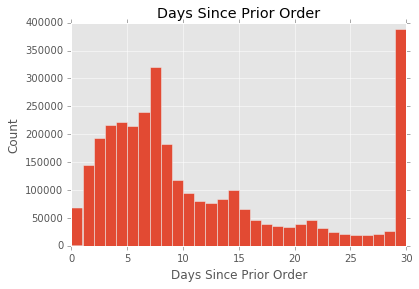

In [12]:
plt.hist('days_since_prior_order',data=orders.dropna(),bins=np.arange(0,31)) #NaNs are dropped
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.title('Days Since Prior Order')

A lot of customers put another order after 7 days or 29 days. Why is there a lot of customers that put another order after 29 days? 

### Analysis of Products Data

In [3]:
#merge orders_products__prior with products, aisles, and departments
temp_merged = pd.merge(products,aisles,on='aisle_id')
products_merged = pd.merge(temp_merged,departments,on='department_id')
merged_order_products__prior = pd.merge(order_products__prior, products_merged, on='product_id',how='left')
merged_order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [14]:
#Top 20 products
product_counts = merged_order_products__prior['product_name'].value_counts()
product_counts.head(20)

Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: product_name, dtype: int64

The top 20 products are mostly fruits and vegetables (except Whole Milk).

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

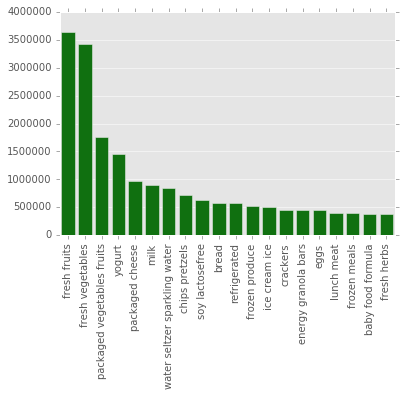

In [15]:
#Top 20 products aisles
aisle_counts = merged_order_products__prior['aisle'].value_counts().head(20)
sns.barplot(aisle_counts.index,aisle_counts.values,color='green')
plt.xticks(rotation=90)

The bar plot of top aisles confirms that the top products and aisles are those of fruits and vegetables.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

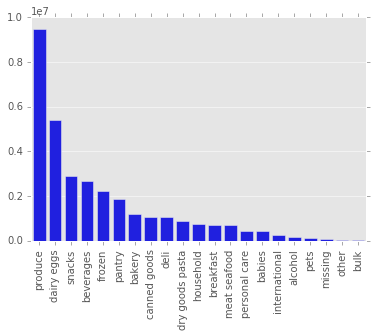

In [16]:
#Top product departments
department_counts = merged_order_products__prior['department'].value_counts()
sns.barplot(department_counts.index,department_counts.values,color='blue')
plt.xticks(rotation=90)

Produce department dominates orders which is consistent with fruits and vegetables as the top products.

(array([ 156748.,  186993.,  207027.,  222081.,  228330.,  227675.,
         220006.,  203374.,  184347.,  165550.,  147461.,  131580.,
         116871.,  103683.,   91644.,   81192.,   71360.,   62629.,
          54817.,   48096.,   41863.,   36368.,   31672.,   27065.,
          23613.,   20283.,   17488.,   15102.,   13033.,   11251.,
           9571.,    8035.,    6991.,    6041.,    5164.,    4407.,
           3681.,    3169.,    2653.,    2272.,    1978.,    1642.,
           1412.,    1227.,    1048.,     895.,     743.,    1171.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 48 Patch objects>)

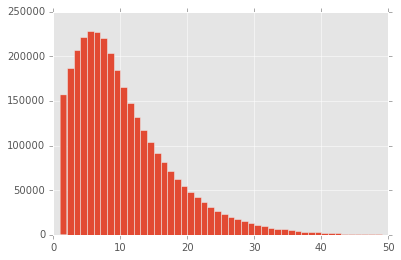

In [17]:
products_in_order = merged_order_products__prior.groupby('order_id')['add_to_cart_order'].max()
plt.hist(products_in_order,bins=np.arange(1,50))

A lot of customers bought 4 to 7 products per order.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


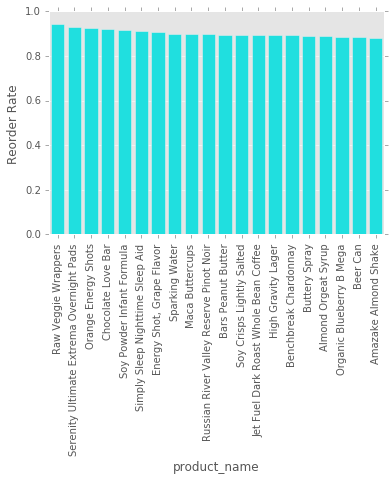

In [18]:
#products with highest reorder rate
products_reorder = merged_order_products__prior.groupby('product_name')['reordered'].mean().sort_values(ascending=False)
products_reorder = products_reorder.head(20)
sns.barplot(products_reorder.index,products_reorder.values,color='aqua')
plt.xticks(rotation='vertical')
plt.ylabel('Reorder Rate')

The barplot above shows various products with the highest reorder rate (>85%).

### Analysis of Users Data

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


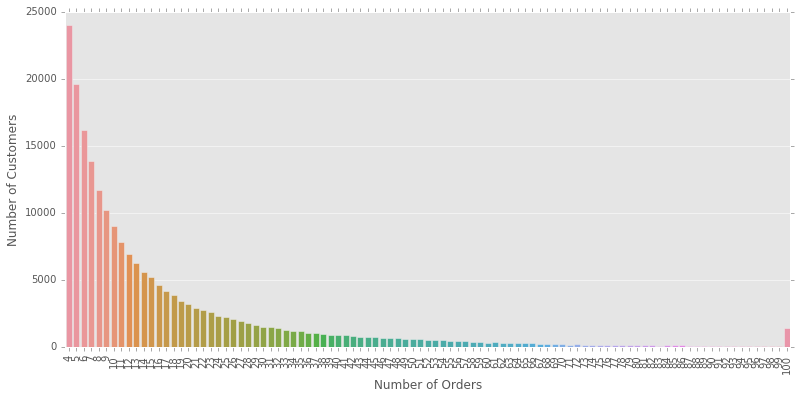

In [19]:
#how many time do each user orders 
prev_orders = orders.groupby('user_id')['order_number'].max().value_counts()
plt.figure(figsize=(13,6))
sns.barplot(prev_orders.index,prev_orders.values)
plt.xticks(rotation='vertical')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')

From the plot above, we can see that the number of orders per customer was between 4 and 100 and in general, the number of customers is decreasing when the number of orders is increasing.

In [20]:
merged_order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


## Extracting Additional Features

In this part, extract and aggregate data (features) at user level, order level, product level, and user-product level.

In [4]:
merged = pd.merge(orders,merged_order_products__prior,on='order_id',how='right')

In [22]:
merged.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs


In [5]:
#user level variables
users = pd.DataFrame()
users['average_days_in_between'] = orders.groupby('user_id')['days_since_prior_order'].mean() 
users['number_of_orders_users'] = orders.groupby('user_id').size()
users['total_items'] = merged.groupby('user_id').size()
users['all_products'] = merged.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = users.all_products.map(len)
users['average_basket'] = users.total_items / users.number_of_orders_users
users=users.reset_index()
users=users.set_index('user_id',drop=False)
print(users.shape)
users.head()

(206209, 7)


,user_id,average_days_in_between,number_of_orders_users,total_items,all_products,total_distinct_items,average_basket
user_id,,,,,,,
1,1,19.000000,11,59,"{17122, 196, 26405, 14084, 46149, 26088, 13032...",18,5.363636
2,2,16.285714,15,195,"{45066, 2573, 18961, 1559, 32792, 23, 22559, 1...",102,13.000000
3,3,12.000000,13,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,6.769231
4,4,17.000000,6,18,"{21573, 17769, 35469, 43704, 37646, 1200, 1186...",17,3.000000
5,5,11.500000,5,37,"{28289, 11777, 40706, 48775, 20754, 6808, 1398...",23,7.400000


In [6]:
#product level variables
products_temp = pd.DataFrame()
products_temp['orders'] = merged.groupby('product_id').size()
products_temp['total_reorders'] = merged['reordered'].groupby(merged.product_id).sum()
products_temp['reorder_rate'] = products_temp['total_reorders'] / products_temp['orders']
products = products.join(products_temp, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del products_temp
print(products.shape)
products.head()

(49688, 7)


,product_id,product_name,aisle_id,department_id,orders,total_reorders,reorder_rate
product_id,,,,,,,
1,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
2,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
3,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
4,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
5,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


In [7]:
#user x product level variables
userproduct = merged.copy()
userproduct['user_product_id'] = userproduct.product_id + userproduct.user_id * 100000
userproduct = userproduct.sort_values('order_number')
userproduct = userproduct.groupby('user_product_id',sort=False).agg({'order_id': ['size', 'last'], 'add_to_cart_order': 'sum'})
userproduct.columns = ['number_of_orders_userproduct','last_order_id','sum_pos_in_cart']
userproduct=userproduct.reset_index()
userproduct=userproduct.set_index('user_product_id',drop=False)
print(userproduct.shape)
del merged
userproduct.head()

(13307953, 4)


,user_product_id,number_of_orders_userproduct,last_order_id,sum_pos_in_cart
user_product_id,,,,
100196,100196,10,2550362,14
12430845961,12430845961,3,1385973,19
12430840332,12430840332,1,3215519,11
7707737067,7707737067,1,833332,6
7707708518,7707708518,1,833332,7


In [8]:
#order level variables
orders=orders.set_index('order_id',drop=False)
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2539329,2539329,1,prior,1,2,8,NaN
2398795,2398795,1,prior,2,3,7,15.0
473747,473747,1,prior,3,3,12,21.0
2254736,2254736,1,prior,4,4,7,29.0
431534,431534,1,prior,5,4,15,28.0


## Train-Test Split

Because the data is obtained from kaggle and kaggle does not post any test cases, the data is split for training (80%) and testing (20%) so that I am able to measure the model's performance measure.

In [9]:
order_products__train = pd.read_csv('order_products__train.csv')

from sklearn.cross_validation import train_test_split
big_train_orders = orders[orders.eval_set == 'train']
train_orders,test_orders = train_test_split(big_train_orders,test_size=0.2)
print(train_orders.shape)
print(test_orders.shape)

train_order_id = train_orders['order_id'].tolist()
test_order_id = test_orders['order_id'].tolist()

train=order_products__train[order_products__train['order_id'].isin(train_order_id)]
test=order_products__train[order_products__train['order_id'].isin(test_order_id)]
train.set_index(['order_id', 'product_id'], inplace=True, drop=False)
test.set_index(['order_id', 'product_id'], inplace=True, drop=False)
print(train.shape)
print(test.shape)

(104967, 7)
(26242, 7)
(1105256, 4)
(279361, 4)


## Building Features Dataframe

The function belows help create a single final dataframe that consists of all of the features (user level, order level, product level, user-product level)

In [10]:
def build_features_df(str_train_or_test):
    if str_train_or_test=='train':
        train_or_test = train_orders
    elif str_train_or_test=='test':
        train_or_test = test_orders
    order_list = []
    product_list = []
    labels = []
    for row in train_or_test.itertuples():
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if str_train_or_test=='train':
            labels += [(order_id, product) in train.index for product in user_products]
        elif str_train_or_test=='test':
            labels += [(order_id, product) in test.index for product in user_products]

    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list

    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.number_of_orders_users)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_in_between)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)

    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders

    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.total_reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    df['z'] = df.user_id * 100000 + df.product_id
    df['userproduct_orders'] = df.z.map(userproduct.number_of_orders_userproduct)
    df['userproduct_orders_ratio'] = (df.userproduct_orders / df.user_total_orders).astype(np.float32)
    df['userproduct_last_order_id'] = df.z.map(userproduct.last_order_id)
    df['userproduct_average_pos_in_cart'] = (df.z.map(userproduct.sum_pos_in_cart) / df.userproduct_orders).astype(np.float32)
    df['userproduct_reorder_rate'] = (df.userproduct_orders / df.user_total_orders).astype(np.float32)
    df['userproduct_orders_since_last'] = df.user_total_orders - df.userproduct_last_order_id.map(orders.order_number)
    df['userproduct_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.userproduct_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    df.drop(['userproduct_last_order_id', 'z'], axis=1, inplace=True)
    return (df,labels)

In [11]:
#build final training dataframe
train_df,labels = build_features_df('train')

In [12]:
train_df.head()

,order_id,product_id,user_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,...,department_id,product_orders,product_reorders,product_reorder_rate,userproduct_orders,userproduct_orders_ratio,userproduct_average_pos_in_cart,userproduct_reorder_rate,userproduct_orders_since_last,userproduct_delta_hour_vs_last
0,2448862,36361,66938,17,298,104,10.4375,17.529412,18,10.0,...,16,839,532.0,0.634088,2,0.117647,16.000000,0.117647,15,9
1,2448862,47626,66938,17,298,104,10.4375,17.529412,18,10.0,...,4,152657,106255.0,0.696038,3,0.176471,14.000000,0.176471,6,7
2,2448862,10763,66938,17,298,104,10.4375,17.529412,18,10.0,...,14,473,292.0,0.617336,3,0.176471,13.333333,0.176471,1,2
3,2448862,42002,66938,17,298,104,10.4375,17.529412,18,10.0,...,16,843,510.0,0.604982,5,0.294118,9.200000,0.294118,4,3
4,2448862,49683,66938,17,298,104,10.4375,17.529412,18,10.0,...,4,97315,67313.0,0.691702,1,0.058824,19.000000,0.058824,5,4


In [13]:
#content of labels, first 100 entries
labels[0:100]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

## Model: Light Gradient Boosting

-First, I built the baseline LGB model using all of the features and standard parameters.
<br>-Then, I plot the feature importances to determine which features have no importance.
<br>-Features that are not important (~0 importance) are removed.
<br>-Then, run GridSearchCV on the training data to find which model parameters are the best.
<br>-Then, using the best parameters, predict the probability on the test data.
<br>-Fine tune the probability treshold by comparing the performance measures (auc,accuracy,f1_score) for each treshold.

In [14]:
#Baseline LGB using all features
features = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'userproduct_orders', 'userproduct_orders_ratio',
       'userproduct_average_pos_in_cart', 'userproduct_reorder_rate', 'userproduct_orders_since_last',
       'userproduct_delta_hour_vs_last'] 

#reformat train dataset
lgb_train_df = lgb.Dataset(train_df[features],
                      label=labels,
                      categorical_feature=['aisle_id','department_id'])

#LGB classifier (binary) with standard parameters
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary',num_leaves=50)
_ = mdl.fit(train_df[features], labels)

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

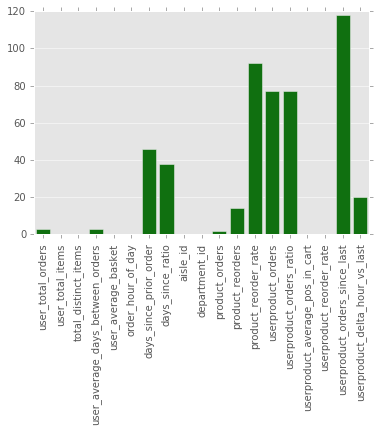

In [15]:
#plot feature importances
sns.barplot(features,mdl.feature_importances_,color='green')
plt.xticks(rotation='vertical')

In [16]:
#Grid Search CV using reduced number of features
features = ['days_since_prior_order', 'days_since_ratio',
       'product_reorders',
       'product_reorder_rate', 'userproduct_orders', 'userproduct_orders_ratio',
        'userproduct_orders_since_last',
       'userproduct_delta_hour_vs_last'] 

lgb_train_df = lgb.Dataset(train_df[features],
                      label=labels)

#Create parameters to search
gridParams = {
    'learning_rate': [0.05,0.1],
    'num_leaves': [40,60,80],
    'max_depth':[4,6,8,10]
    }

#Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary')

#Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5, n_jobs=-1)

#Run the grid
grid.fit(train_df[features], labels)

#best parameters found
print(grid.best_params_)
print(grid.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 21.9min finished


{'num_leaves': 80, 'max_depth': 8, 'learning_rate': 0.1}
0.9089150277322979


In [17]:
#build test dataset
df_test, labels_test = build_features_df('test')

In [18]:
#fit the best model
final_mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary',
        learning_rate = grid.best_params_['learning_rate'],
        num_leaves = grid.best_params_['num_leaves'],
        max_depth = grid.best_params_['max_depth'])
final_mdl.fit(train_df[features], labels)

#predict probability
df_test['pred']=final_mdl.predict_proba(df_test[features])[:,1]
df_test['actual']=labels_test

In [19]:
#choose treshold based on performance measures
TRESHOLD = [0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4]
for tre in TRESHOLD:
    df_test['prediction']=df_test['pred'].apply(lambda x: x>tre).astype(np.int8)
    print('treshold:',tre,'| auc:',roc_auc_score(df_test.actual, df_test.prediction),
          '| accuracy:',accuracy_score(df_test.actual, df_test.prediction),
         '| f1_score:',f1_score(df_test.actual, df_test.prediction))

treshold: 0.2 | auc: 0.67632792038 | accuracy: 0.470285485662 | f1_score: 0.257851330128
treshold: 0.22 | auc: 0.735598511472 | accuracy: 0.660585388835 | f1_score: 0.325154478797
treshold: 0.24 | auc: 0.744968887832 | accuracy: 0.743649429573 | f1_score: 0.364882480685
treshold: 0.26 | auc: 0.740120590124 | accuracy: 0.801466253791 | f1_score: 0.397387231856
treshold: 0.28 | auc: 0.728292925501 | accuracy: 0.837987064486 | f1_score: 0.418725540368
treshold: 0.3 | auc: 0.711724174752 | accuracy: 0.862425219518 | f1_score: 0.429000958019
treshold: 0.32 | auc: 0.697397089728 | accuracy: 0.875615230005 | f1_score: 0.429843409187
treshold: 0.34 | auc: 0.681755165205 | accuracy: 0.885842430096 | f1_score: 0.424868056177
treshold: 0.36 | auc: 0.666427804658 | accuracy: 0.893129902013 | f1_score: 0.414799114594
treshold: 0.38 | auc: 0.651000160434 | accuracy: 0.898449466505 | f1_score: 0.399678113465
treshold: 0.4 | auc: 0.635834591951 | accuracy: 0.902463997652 | f1_score: 0.38049125234


In [23]:
#pick 0.
df_test.head()

,order_id,product_id,user_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,...,product_reorder_rate,userproduct_orders,userproduct_orders_ratio,userproduct_average_pos_in_cart,userproduct_reorder_rate,userproduct_orders_since_last,userproduct_delta_hour_vs_last,pred,actual,prediction
0,437845,24064,21550,6,89,63,8.2,14.833333,17,0.0,...,0.469945,1,0.166667,8.0,0.166667,2,3,0.215188,0,0
1,437845,17923,21550,6,89,63,8.2,14.833333,17,0.0,...,0.582133,1,0.166667,12.0,0.166667,3,2,0.228745,0,0
2,437845,42890,21550,6,89,63,8.2,14.833333,17,0.0,...,0.575758,1,0.166667,9.0,0.166667,5,0,0.211301,0,0
3,437845,12555,21550,6,89,63,8.2,14.833333,17,0.0,...,0.429825,1,0.166667,14.0,0.166667,2,3,0.215188,0,0
4,437845,22159,21550,6,89,63,8.2,14.833333,17,0.0,...,0.515058,1,0.166667,19.0,0.166667,3,2,0.219828,0,0


The best treshold based on f1_score is 0.32, the confusion matrix is plotted below.

In [21]:
#draw confusion matrix
treshold = 0.32
df_test['prediction']=df_test['pred'].apply(lambda x: x>treshold).astype(np.int8)
confusion_matrix(df_test.actual, df_test.prediction)

array([[1400229,  122737],
       [  87425,   79221]])